In [66]:
%load_ext autoreload
%autoreload 2
import arch.unitroot
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mpl_ticker
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from datetime import datetime
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from typing import Any, Dict, Optional, Tuple, Union

from backtest import (
    load_data_crypto,
    select_asset_universe_crypto,
    form_pairs_crypto,
    estimate_hedge_ratio,
    compute_signal,
    allocate_positions,
    run_backtest,
)
from dist_metrics.basic_distance_metrics import (
    ssd,
    manhattan,
    euclidean,
    correlation_distance,
)

from dist_metrics.temporal_distances import (
    dtw_distance,
    lcs_distance,
)

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 40)
pd.set_option('display.precision', 4)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
config = {
    "CRYPTO_CSV_PATH": "prices.csv",
    "FUNDING_RATES_PATH": "funding_rates.csv",
    "SAMPLE_PRICES_PATH": "/share/data/jfuest_crypto/sample/prices.csv",
    "criterion": "quote_volume", # criterion, must be one of 'quote_volume', 'amihud', 'kyle'
    "liquidity_interval": 60, # Length of intervals for aggergatuion of the liquidity measure 
    "liquidity_filter_length": 60*24, # Coins must have been top n liquid for at least this many minutes
    "max_rank": 50, # highest liquidity rank allowed
    "dist_metric": "ssd", # options: 'ssd', 'manhattan', 'euclidean', 'correlation', 'dtw', 'lcs'
    "n_pairs": 5, # Number of pairs to form
    'HEDGE_RATIO_METHOD': 'ols', # options (for now) are ols and unit
    'COINT_THRESHOLD': 0.05,
    'Z_THRESHOLD': 2.0, # z-score threshold for cointegration
    'ESTIMATION_PERIOD': 60*12, # Length of estimation period for hedge ratio estimation
    'EXIT_STRATEGY': 'convergence',
    'MAX_LEVERAGE': 0.05,
    #-------Below are backtest parameters that still need to get adjusted or understood-------
    # Transaction cost as a fraction of trade value in percentage (0.0001 = 1 bps)
    'TRANSACTION_COST': 0.0002, # Binance MM fee
    # Daily borrowing cost for leverage in percentage (0.0001 = 1 bps); multiply by 252 to convert to annual rate
    'BORROW_RATE_DAILY': 0,
    # Leverage rate daily on balanced leverage in percentage (0.0001 = 1 bps); multiply by 252 to convert to annual rate
    'LEVERAGE_RATE_DAILY': 0,
    # Margin rate daily on unbalanced (excess) leverage in percentage (0.0001 = 1 bps); multiply by 252 to convert to annual rate
    'MARGIN_RATE_DAILY': 0,
    # Initial cash amount
    'INITIAL_CASH': 1_000_000.0,
    'FORMATION_PERIOD': 60*24, #
    'TRADING_PERIOD': 60*24, #
    'SAVE_RESULTS': True, # Whether to save the results to a CSV file
}

Price df shape at load: (260640, 188)

Prices head:


,AAVE,ACH,ADA,AGIX,ALGO,ALICE,ALPHA,AMB,ANKR,ANT,...,XLM,XMR,XRP,XTZ,XVS,YFI,ZEC,ZEN,ZIL,ZRX
close_time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:59.999000+00:00,51.97,NaN,0.2457,NaN,0.1723,1.056,0.0666,NaN,0.0153,2.230,...,0.0711,147.15,0.3391,0.716,NaN,5086.0,37.27,9.224,0.0158,0.1479
2023-01-01 00:01:59.999000+00:00,51.96,NaN,0.2458,NaN,0.1723,1.057,0.0666,NaN,0.0153,2.231,...,0.0710,147.14,0.3391,0.716,NaN,5086.0,37.30,9.223,0.0158,0.1478
2023-01-01 00:02:59.999000+00:00,51.93,NaN,0.2456,NaN,0.1721,1.056,0.0666,NaN,0.0154,2.231,...,0.0710,147.10,0.3387,0.716,NaN,5083.0,37.30,9.224,0.0158,0.1478
2023-01-01 00:03:59.999000+00:00,51.92,NaN,0.2456,NaN,0.1720,1.057,0.0666,NaN,0.0153,2.229,...,0.0710,147.11,0.3387,0.715,NaN,5083.0,37.28,9.225,0.0158,0.1478
2023-01-01 00:04:59.999000+00:00,51.94,NaN,0.2455,NaN,0.1721,1.055,0.0666,NaN,0.0154,2.232,...,0.0709,147.31,0.3384,0.715,NaN,5082.0,37.28,9.224,0.0158,0.1476


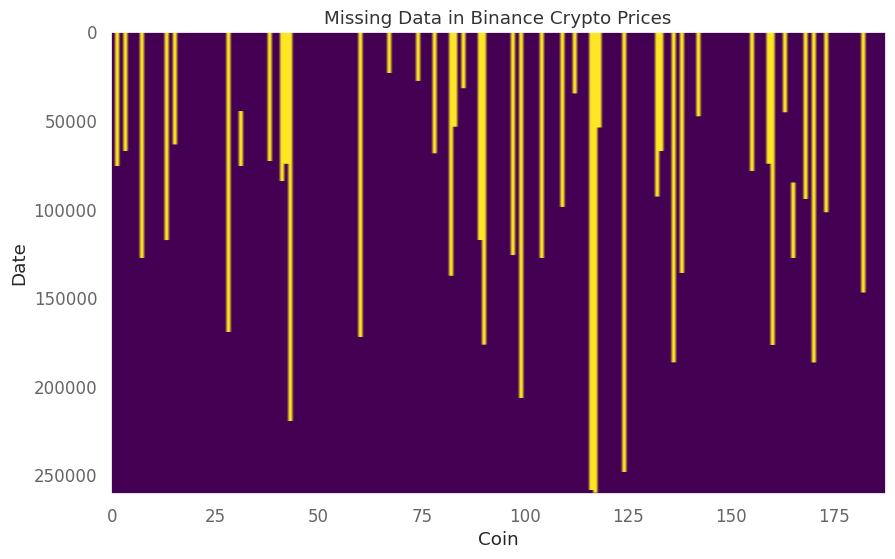

In [68]:
prices_unselected, returns_unselected, tickers, amihud, kyle, dollar_vol, funding_rates = load_data_crypto(config, verbose=True)

In [69]:
test_date = pd.to_datetime("2023-02-01 00:00:59.999000+00:00", utc=True)
selected_prices, selected_returns, coins = select_asset_universe_crypto(
    prices_unselected.copy(),
    returns_unselected.copy(),
    amihud,
    kyle,
    dollar_vol,
    date=test_date,
    config=config,
)

Now, let's test it. Execute this cell, which runs your asset filter in a loop and displays your asset filter's selection over time as a boolean matrix. Try different values for `lookback_period` and `max_abs_return` to see how they affect the selection, but finish by running it with `lookback_period=252` and `max_abs_return=0.5`.

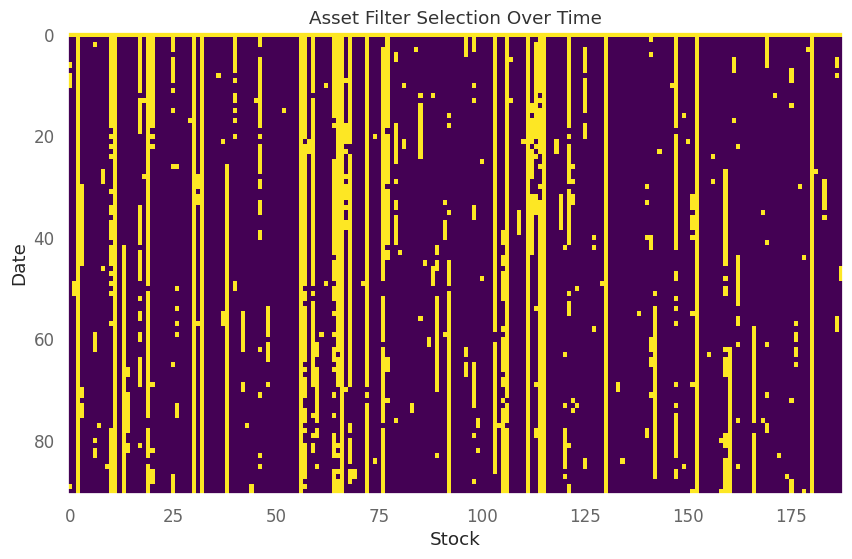

In [70]:
sample_freq = config["liquidity_interval"] * 48
asset_filter = pd.DataFrame(index=prices_unselected.index[::sample_freq], columns=tickers, data=False)

for date in prices_unselected.index[::sample_freq]:
    selected_stocks, selected_rets, selected_uni = select_asset_universe_crypto(
        prices_unselected.copy(),
        returns_unselected.copy(),
        amihud.copy(),
        kyle.copy(),
        dollar_vol.copy(),
        date=date, 
        config=config,
    )
    asset_filter.loc[date, selected_stocks.columns] = True

plt.imshow(asset_filter, aspect='auto', cmap='viridis', interpolation=None)
plt.xlabel('Stock')
plt.ylabel('Date')
plt.title('Asset Filter Selection Over Time')
plt.grid(False)
plt.show()

In [71]:
def form_pairs_crypto(prices: pd.DataFrame, config: dict) -> pd.DataFrame:
    """
    Computes the distance between all pairs of stocks based on their normalized price series
    and returns information on the top `n_pairs` pairs with lowest distances.
    
    Parameters:
    -----------
    prices: pd.DataFrame
        Dataframe of stock prices with dates as index and tickers as columns
    config: dict
        Configuration parameters, containing the key `n_pairs`, with a value such as 20,
        as well as the distance metric to use, specified by the key `dist_metric`.
        
    Returns:
    --------
    pd.DataFrame
        Dataframe with top `n_pairs` pairs sorted by distance
    """
    num_pairs = config["n_pairs"]
    normalized_prices = (prices / prices.iloc[0]).copy()

    distances = []
    for stock_1, stock_2 in itertools.combinations(prices.columns, 2):
        
        stock_1_prices = normalized_prices[stock_1]
        stock_2_prices = normalized_prices[stock_2]
        match config['dist_metric']:
            case "ssd":
                distance = ssd(stock_1_prices, stock_2_prices)
            case "manhattan":
                distance = manhattan(stock_1_prices, stock_2_prices)
            case "euclidean":
                distance = euclidean(stock_1_prices, stock_2_prices)
            case "correlation":
                distance = correlation_distance(stock_1_prices, stock_2_prices)
            case "dtw":
                distance = dtw_distance(stock_1_prices, stock_2_prices)
            case "lcs":
                distance = lcs_distance(stock_1_prices, stock_2_prices)
            case _:
                raise ValueError(f"Unrecognized distance metric: {config['dist_metric']}")
        distances.append({'stock1': stock_1, 'stock2': stock_2, 'distance': distance})

    pairs_df_full = pd.DataFrame(distances)
    pairs_df_full = pairs_df_full.sort_values(by='distance').reset_index(drop=True)
    pairs_df = pairs_df_full.head(num_pairs)
    return pairs_df

,stock1,stock2,distance
0,ADA,HOOK,0.0
1,MAGIC,MASK,0.0
2,MAGIC,MATIC,0.0
3,MAGIC,NEAR,0.0
4,MAGIC,MANA,0.0


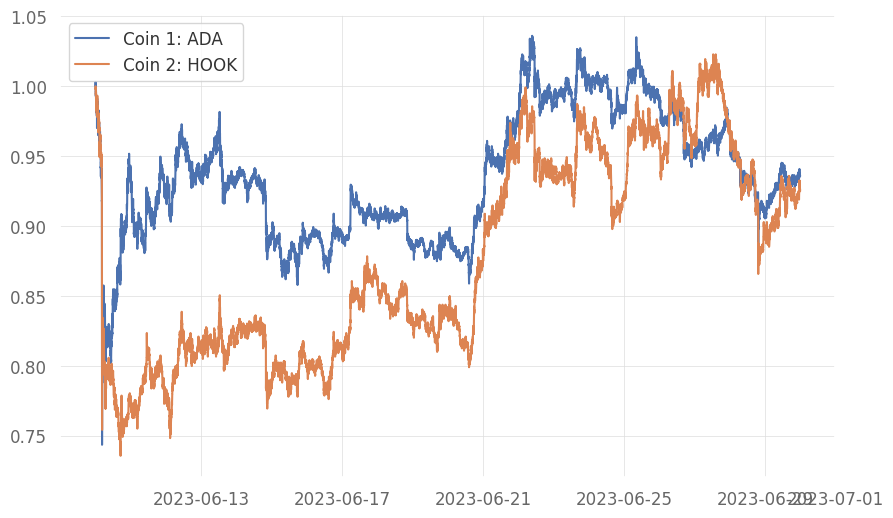

In [72]:
selected_prices, selected_returns, coins = select_asset_universe_crypto(
    prices_unselected.copy(),
    returns_unselected.copy(),
    amihud,
    kyle,
    dollar_vol,
    date=test_date,
    config=config,
)

# Compute distances
pairs = form_pairs_crypto(selected_prices, config)
display(pairs)

# Plot the top pair's normalized prices over the (approximate) lookback window
ticker1 = pairs.loc[0, 'stock1']
ticker2 = pairs.loc[0, 'stock2']

s1 = selected_prices[date - pd.Timedelta(days=20):date][ticker1]
s2 = selected_prices[date - pd.Timedelta(days=20):date][ticker2]
s1 = s1 / s1.iloc[0]
s2 = s2 / s2.iloc[0]
plt.plot(s1, label=f'Coin 1: {ticker1}')
plt.plot(s2, label=f'Coin 2: {ticker2}')
plt.legend()
plt.show()

In [73]:
def estimate_hedge_ratio(prices: pd.DataFrame, pairs: pd.DataFrame, config: dict) -> pd.DataFrame:
    """
    Estimates the betas and cointegrating relationships between the top K pairs and returns this information.
    
    Parameters:
    -----------
    prices: pd.DataFrame
        Dataframe of stock prices with dates as index and tickers as columns
    pairs: pd.DataFrame
        Dataframe with pairs information from form_pairs()
        
    Returns:
    --------
    pd.DataFrame
        Dataframe with betas and cointegration information for each pair
    """
    # Your code here
    results = []
    # loop over pairs of stocks and compute betas, conintegration info
    for _, row  in pairs.iterrows(): 
        stock_1, stock_2 = row['stock1'], row['stock2']
        # extract price series for each stock
        prices_1, prices_2 = prices[stock_1], prices[stock_2]
        # compute hedge ratio between the two stocks
        if config['HEDGE_RATIO_METHOD'] == 'ols': 
            # regress stock 2 on stock 1
            res = stats.linregress(prices_1, prices_2)
            # hedge ratio = slope of ols regression
            hedge_ratio_signed = res.slope
        elif config['HEDGE_RATIO_METHOD'] == 'unit': 
            hedge_ratio_signed = 1.0
        elif config['HEDGE_RATIO_METHOD'] == 'mvhr': 
            # custom method based on research: min variance hedge ratio
            # MVHR = cov(p1, p2)/var(p1)
            cov = np.cov(prices_1, prices_2)[0, 1] # off diag element captures cov
            var = np.var(prices_1)
            hedge_ratio_signed = cov / var
        else: raise ValueError("Unrecognized hedge ratio method.")

        # compute spread
        spread = prices_2 - hedge_ratio_signed * prices_1
        # perform ADF test on the spread
        spread = spread.dropna()  # drop NaN values to avoid errors in ADF test
        adf = arch.unitroot.ADF(spread)
        # extract ADF statistic, p-value
        adf_stat, adf_pvalue = adf.stat, adf.pvalue
        # store stats in table
        is_cointegrated = adf_pvalue <= config['COINT_THRESHOLD']   

        results.append({'stock1': stock_1, 'stock2': stock_2, 
                        'hedge_ratio': abs(hedge_ratio_signed), 
                        'distance': row['distance'], 'adf_stat': adf_stat, 
                        'adf_pvalue': adf_pvalue, 
                        'is_cointegrated': is_cointegrated})      

    results_df = pd.DataFrame(results)
    # filter results to only include pairs with p-value less than threshold
    filtered_results = results_df[results_df['is_cointegrated']].reset_index(drop=True)

    return filtered_results

Now we'll test your implementation. Run the cell below. The spread you observe should appear to be mostly oscillating around its mean value.

In [74]:
hedge_ratios = estimate_hedge_ratio(selected_prices, pairs, config)
display(hedge_ratios)

# Plot the first hedge ratio as a spread
pair_idx = 0

ticker1 = hedge_ratios['stock1'].iloc[pair_idx]
ticker2 = hedge_ratios['stock2'].iloc[pair_idx]
hr = hedge_ratios['hedge_ratio'].iloc[pair_idx]
s1 = selected_prices[ticker1]
s2 = selected_prices[ticker2]
spread = s1 - hr * s2
spread.plot()
plt.title(f'Spread: {ticker1} - {hr:.2f} * {ticker2}')
plt.show()

InfeasibleTestException: A minimum of 4 observations are needed to run an ADF with trend c and the user-specified number of lags.

Now that we have identified cointegrated pairs and estimated their hedge ratios, we need to generate trading signals based on the divergence and convergence of these pairs. This is a critical component of the Gatev et al. pairs trading strategy.

We've created a function called `compute_signal` in `backtest.py`. Your task is to implement this function according to the Gatev et al. methodology. Complete the following steps:

1. Loop through each pair in the `hedge_ratios` dataframe.

2. Extract the price series for both stocks in each pair from the `prices` dataframe.

3. Calculate the spread between the two stocks using the hedge ratio. The spread should be calculated as: `spread = price2 - hedge_ratio * price1`

4. Implement a rolling window calculation to standardize the spread:
   - Calculate the rolling mean of the spread using a window size of `config['ESTIMATION_PERIOD']`
   - Calculate the rolling standard deviation using the same window size
   - Compute the z-score: `z_score = (spread - rolling_mean) / rolling_std`

5. Initialize an empty signal dataframe for the pair.

6. Loop through time for the pair, generating trading signals based on the z-score and price convergence:
   - **Entry Conditions**:
     - If z-score < -`config['Z_THRESHOLD']`, enter a long spread position (signal = 1)
     - If z-score > `config['Z_THRESHOLD']`, enter a short spread position (signal = -1)
   
   - **Exit Conditions**:
     - According to Gatev et al., positions should be closed when the normalized prices cross (converge)
     - You need to track which normalized price was higher/lower at trade entry
     - Close the position (signal = 0) when the normalized prices cross back over each other

7. For each pair, store the following in the signals dictionary:
   - stock1 and stock2 identifiers
   - hedge_ratio
   - signal series
   - z_score series
   - any additional metadata you find useful e.g. for debugging, such as series for the spread, crosses, mean, volatility, etc.

8. Return the completed signals dictionary.

## Important Implementation Details

- You must properly track the state of each trade (whether you're in a trade or not)
- You need to record which normalized price was higher/lower at trade entry to determine when price convergence occurs
- The signals should be a time series with the same index as the price data
- For each date, the signal should be:
  - 1: Long spread (short stock1, long stock2)
  - -1: Short spread (long stock1, short stock2)
  - 0: No position

## Example Output

The returned dictionary should have keys for each pair and values containing the signal information:

```python
{
    'STOCK1_STOCK2': {
        'stock1': 'STOCK1',
        'stock2': 'STOCK2',
        'hedge_ratio': 1.25,
        'signal': pd.Series(
            data=[0, 0, 1, 1, 0, -1, -1, 0, ...],
            index=pd.DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04', 
                                   '2009-01-05', '2009-01-08', '2009-01-09', '2009-01-10', ...])
        ), 
        'z_score': pd.Series(
            data=[0.5, 1.8, 2.2, 1.9, 0.8, -1.2, -2.1, -1.8, ...],
            index=pd.DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04', 
                                   '2009-01-05', '2009-01-08', '2009-01-09', '2009-01-10', ...])
        ),
        # Add any additional metadata you find useful
    },
    # Additional pairs...
}
```

<!-- For extra credit (1 points): Implement an alternative exit strategy in addition to the price convergence method from Gatev et al. Add a configuration parameter `EXIT_STRATEGY` that allows switching between:

- "convergence" - Exit when prices cross (default, as in Gatev et al.)
- "z_score" - Exit when the z-score returns to zero (or within a small threshold) -->

<!-- Don't do this extra credit above, it's commented out ;) -->

Our implementation is about 55 lines, but this can be done in more or fewer lines.

Complete the function in `backtest.py` and paste the complete `compute_signal` function below:

In [ ]:
def compute_signal(prices: pd.DataFrame, hedge_ratios: pd.DataFrame, config: dict) -> dict:
    """
    Computes trading signals for each spread based on z-score.
    
    Parameters:
    -----------
    prices: pd.DataFrame
        Dataframe of stock prices with dates as index and tickers as columns
    hedge_ratios: pd.DataFrame
        Dataframe with hedge ratios and cointegration information from estimate_hedge_ratio
    config: dict
        Configuration parameters, containing: e.g. signal threshold Z_THRESHOLD, such as 2.0
        
    Returns:
    --------
    dict
        Dictionary with signals for each pair
    """
    # Your code here
    signal_threshold = config['Z_THRESHOLD']
    signals = {}

    # loop through each pair in hedge_ratios
    for _, row in hedge_ratios.iterrows():
        stock_1, stock_2 = row['stock1'], row['stock2']
        # extract price series of both stocks
        stock_1_prices, stock_2_prices = prices[stock_1], prices[stock_2]
        hedge_ratio = row['hedge_ratio']
        # calculate spread between the two stocks
        spread = stock_2_prices - hedge_ratio * stock_1_prices
        # standardize spread with rolling window calculation
        window_size = config['ESTIMATION_PERIOD']
        rolling_mean = spread.rolling(window=window_size).mean()
        rolling_std = spread.rolling(window=window_size).std()
        z_score = (spread - rolling_mean) / rolling_std
        # initialize empty signal for the pair of stocks
        signal = pd.Series(data=0, index=prices.index) # initialize to all 0 (no pos)

        # loop through time for the pair and generate trade signal
        in_trade = False
        # calculate normalized prices
        s1_prices_norm = stock_1_prices / stock_1_prices.iloc[0]
        s2_prices_norm = stock_2_prices / stock_2_prices.iloc[0]

        for date in signal.index:
            # if not in trade, check entry conditions
            if not in_trade:
                if z_score[date] < -signal_threshold:
                    signal[date] = 1 # enter long spreaad pos
                    entry_dir = 'long' # record whether long/short later for exit conditions
                    in_trade = True
                elif z_score[date] > signal_threshold:
                    signal[date] = -1 # enter short spread pos
                    entry_dir = 'short'
                    in_trade = True

            # if in trade, check exit conditions
            else: 
                # check convergence
                if entry_dir == 'long' and s2_prices_norm[date] >= s1_prices_norm[date]: 
                    signal[date] = 0 # close pos
                    in_trade = False
                elif entry_dir == 'short' and s2_prices_norm[date] <= s1_prices_norm[date]: 
                    signal[date] = 0 # close pos   
                    in_trade = False
                # still in trade but don't need to exit -> mark date as corect signal
                else: 
                    signal[date] = 1 if entry_dir == 'long' else -1
        
        # add pair information to signals dictionary
        pair_data = {'stock1': stock_1, 'stock2': stock_2, 'hedge_ratio': hedge_ratio, 
                     'signal': signal, 'z_score': z_score}
        signals[stock_1 + '_' + stock_2] = pair_data
   
    
    return signals

Now we'll test your implementation. Run the cell below.

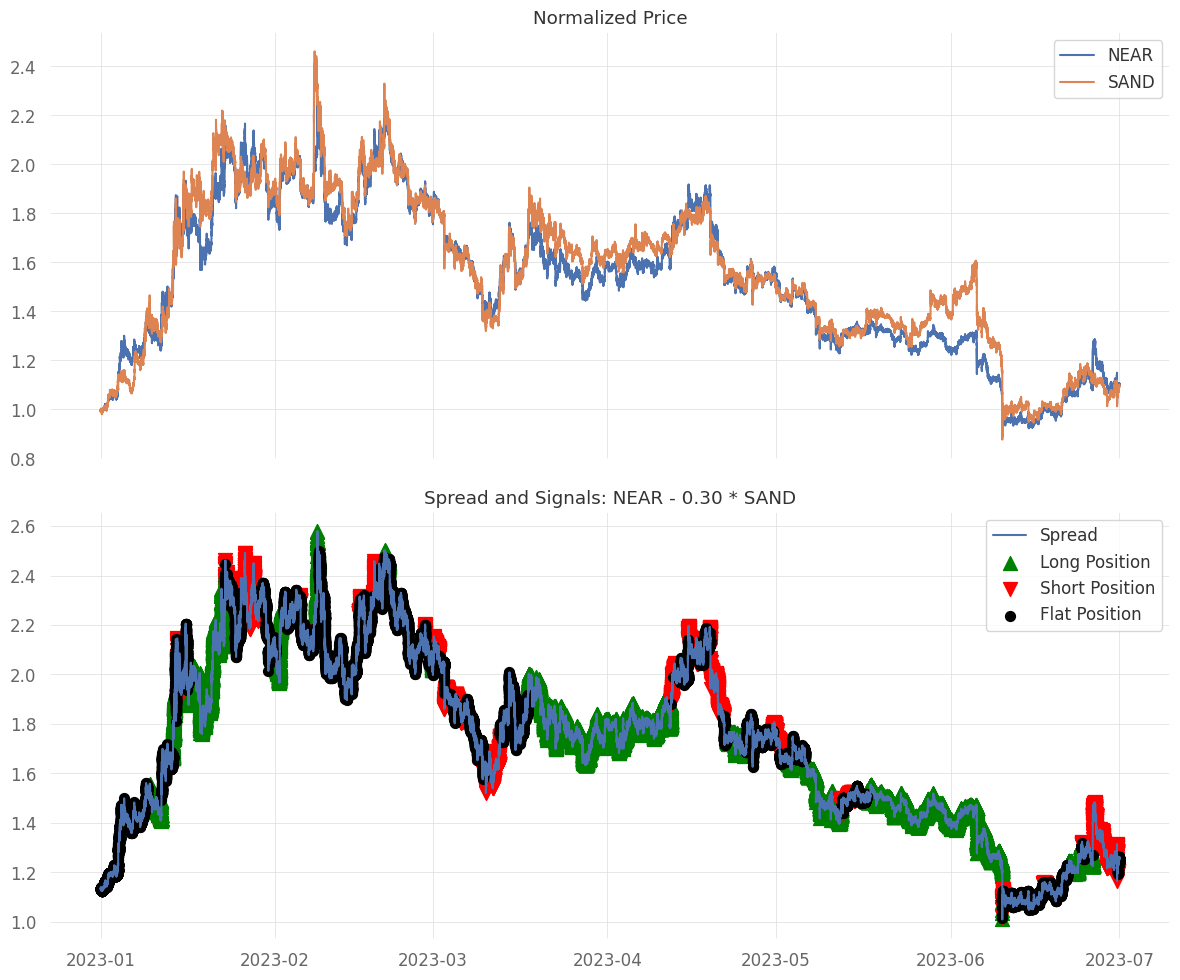

In [ ]:
# Compute signals
signals = compute_signal(selected_prices, hedge_ratios, config)
pair_idx = 0

# Get ticker info for the selected pair
ticker1 = hedge_ratios['stock1'].iloc[pair_idx]
ticker2 = hedge_ratios['stock2'].iloc[pair_idx]
hr = hedge_ratios['hedge_ratio'].iloc[pair_idx]

# Create figure with two subplots sharing x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot normalized prices on first subplot
s1 = selected_prices[ticker1]
s2 = selected_prices[ticker2]
s1_norm = s1 / s1.iloc[0]
s2_norm = s2 / s2.iloc[0]
ax1.plot(s1_norm.index, s1_norm, label=ticker1)
ax1.plot(s2_norm.index, s2_norm, label=ticker2)
ax1.set_title('Normalized Price')
ax1.legend()

# Plot spread and signals on second subplot
spread = s1 - hr * s2
ax2.plot(spread.index, spread, label='Spread')

# Add signals to the second subplot
pair_signals = signals[f"{ticker1}_{ticker2}"]
entry_long = np.where(pair_signals['signal'] == -1)[0]
entry_short = np.where(pair_signals['signal'] == 1)[0]
exit_points = np.where(pair_signals['signal'] == 0)[0]

ax2.scatter(spread.index[entry_long], spread.iloc[entry_long], 
            color='green', marker='^', s=100, label='Long Position')
ax2.scatter(spread.index[entry_short], spread.iloc[entry_short], 
            color='red', marker='v', s=100, label='Short Position')
ax2.scatter(spread.index[exit_points], spread.iloc[exit_points], 
            color='black', marker='o', s=50, label='Flat Position')
ax2.set_title(f'Spread and Signals: {ticker1} - {hr:.2f} * {ticker2}')
ax2.legend()

plt.tight_layout()
plt.show()

# Question 6

(8 points)

Last step of the implementation! Now we're going to convert our set of signals for each pair into positions using the `allocate_positions` function. This function will take a set of signals for each pair and allocate the available capital to each pair based on the signals for the given date. The function will then return a set of positions for each stock for the given date. We definitely don't claim this to be the best way to allocate among the pairs, but it's a simple baseline. 

Let's get into it:

1. Initialize an empty dictionary to store positions for each stock.

2. Add a few checks to handle edge cases:
   - If the current date is not in the price data, return empty positions
   - If portfolio cash is None or zero/negative, return empty positions

3. Collect active pairs for the current date:
   - Iterate through the signals dictionary
   - For each pair, extract stock1, stock2, and the hedge ratio
   - Skip pairs where we don't have price data for both stocks
   - Get the signal with a one-day lag (yesterday's signal for today's execution)
   - Skip signals that aren't for the current date or are zero/NaN
   - Store active pairs with their relevant information (stocks, hedge ratio, signal value, current prices)

4. If no active pairs are found, return empty positions.

5. Allocate capital equally across all active pairs:
   - Calculate `capital_per_pair = (portfolio_cash * config['MAX_LEVERAGE']) / number of active pairs`

6. For each active pair:
   - Initialize positions for both stocks if they don't exist in the positions dictionary
   - Calculate balanced position sizes using a notional ratio approach:
     - `notional_ratio = (hedge_ratio * price2) / price1`
     - `shares1 = capital_per_pair / (price1 * (1 + notional_ratio))`
     - `shares2 = shares1 * hedge_ratio`
   - Update positions based on signal:
     - `positions[stock1] += -signal_value * shares1`
     - `positions[stock2] += signal_value * shares2`

7. Return the positions dictionary.

The `allocate_positions` function takes the following parameters:

- `signals`: A dictionary with signal information for each pair. Note that this contains signals for the entire trading period, not just the current date. Make sure to avoid using signals from the future!
- `config`: Configuration parameters, containing MAX_LEVERAGE
- `prices`: DataFrame with stock prices for the entire trading period (dates as index, tickers as columns)
- `date`: Current date for price and signal reference
- `portfolio_cash`: Available cash in the portfolio

It returns a dictionary mapping stock names to position sizes (number of shares).

Our implementation is fairly naive and requires about 40 lines of code. You can implement it in fewer or more lines.

Complete the function in `backtest.py` and paste the complete `allocate_positions` function below:

In [ ]:
def allocate_positions(
    signals: dict,
    config: dict,
    prices: pd.DataFrame,
    date: pd.Timestamp,
    portfolio_cash: float,
) -> dict:
    """
    Simple position sizing that allocates cash equally across all active pairs.
    
    Parameters:
    -----------
    signals: dict
        Dictionary with signal information for each pair
    config: dict
        Configuration parameters, containing MAX_LEVERAGE
    prices: pd.DataFrame
        Dataframe of stock prices with dates as index and tickers as columns
    date: pd.Timestamp
        Current date for price reference
    portfolio_cash: float
        Available cash in the portfolio
    
    Returns:
    --------
    dict
        Dictionary with position information for each stock
    """
    # Your code here
    positions = {} # will store positions for each stock: stock_name -> num shares

    # handle edge cases
    if date not in prices.index:
        return positions
    if portfolio_cash is None or portfolio_cash <= 0:
        return positions
    
    # collect active pairs for the current date
    active_pairs = []
    for pair_str, signal_dict in signals.items():
        stock_1, stock_2 = signal_dict['stock1'], signal_dict['stock2']
        hedge_ratio = signal_dict['hedge_ratio']
        signal = signal_dict['signal'] # Series representing the trading signal

        # skip pairs where we don't have price data for both stocks
        if stock_1 not in prices.columns or stock_2 not in prices.columns:
            continue
        # get signal from yesterday for today's execution
        date_idx = signal.index.get_loc(date)
        if date_idx == 0: # no previous day
            continue
        signal_value = signal.iloc[date_idx - 1] # signal from yesterday
        # skip zero/NaN signals
        if signal_value == 0 or pd.isna(signal_value):
            continue
        # otherwise, store dict of info for the active pair
        active_pairs.append({'stock1': stock_1, 'stock2': stock_2, 'hedge_ratio': hedge_ratio, 
                            'signal': signal_value, 'price1': prices.at[date, stock_1], 
                            'price2': prices.at[date, stock_2]})

    # if no activate pairs found, return empty positions
    if len(active_pairs) == 0:
        return positions
    
    # allocate capital equally across all active pairs
    num_active_pairs = len(active_pairs)
    capital_per_pair = (portfolio_cash * config['MAX_LEVERAGE']) / num_active_pairs

    for pair in active_pairs:
        # extract info for pair
        stock1, stock2 = pair['stock1'], pair['stock2']
        price1, price2 = pair['price1'], pair['price2']
        hedge_ratio = pair['hedge_ratio']
        signal_value = pair['signal']

        # calculate balanced position sizes using a notional ratio approach
        notional_ratio = (hedge_ratio * price2) / price1
        shares1 = capital_per_pair / (price1 * (1 + notional_ratio))
        shares2 = shares1 * hedge_ratio

        # initialize positions for both stocks if they don’t exist in the positions dictionary
        if stock1 not in positions: 
            positions[stock1] = 0
        if stock2 not in positions:
            positions[stock2] = 0 
        # update positions based on signal
        positions[stock1] += -signal_value * shares1
        positions[stock2] += signal_value * shares2
    
    return positions

Now, we'll test your implementation. Run the following cell and observe the positions. They should appear to follow most of the signals, more or less. Recall that any single stock may be involved in multiple pairs, and so the positions you observe here may not be perfectly correlated with the signals, and may not be perfectly offset at all times. This is expected behavior.

,NEAR,SAND
close_time,,
2023-01-01 00:00:59.999000+00:00,0.0,0.0
2023-01-01 00:01:59.999000+00:00,0.0,0.0
2023-01-01 00:02:59.999000+00:00,0.0,0.0
2023-01-01 00:03:59.999000+00:00,0.0,0.0
2023-01-01 00:04:59.999000+00:00,0.0,0.0
...,...,...
2023-06-30 23:55:59.999000+00:00,0.0,0.0
2023-06-30 23:56:59.999000+00:00,0.0,0.0
2023-06-30 23:57:59.999000+00:00,0.0,0.0


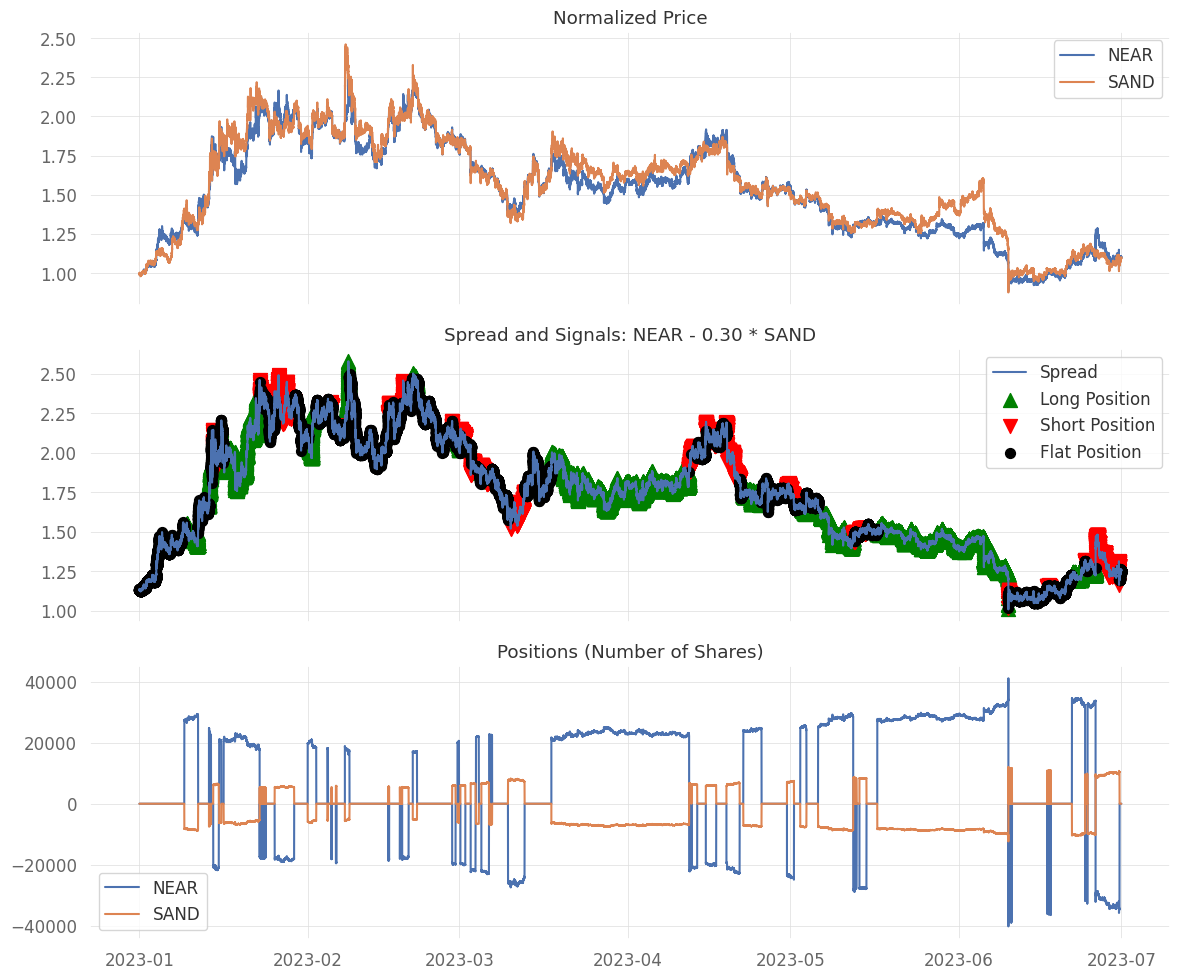

In [ ]:
pair_idx = 0

# Get ticker info for the selected pair
ticker1 = hedge_ratios['stock1'].iloc[pair_idx]
ticker2 = hedge_ratios['stock2'].iloc[pair_idx]
hr = hedge_ratios['hedge_ratio'].iloc[pair_idx]

# Compute the positions using allocate_positions
positions_t1 = {}
positions_t2 = {}
for date in selected_prices.index:
    positions_t1[date] = allocate_positions(
        signals, config, selected_prices, pd.Timestamp(date), 1_000_000
    ).get(ticker1, 0)
    positions_t2[date] = allocate_positions(
        signals, config, selected_prices, pd.Timestamp(date), 1_000_000
    ).get(ticker2, 0)

positions = pd.DataFrame(
    {ticker1: positions_t1.values(), ticker2: positions_t2.values()},
    index=selected_prices.index,
)
display(positions)

# Create figure with three subplots sharing x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot normalized prices on first subplot
s1 = selected_prices[ticker1]
s2 = selected_prices[ticker2]
s1_norm = s1 / s1.iloc[0]
s2_norm = s2 / s2.iloc[0]
ax1.plot(s1_norm.index, s1_norm, label=ticker1)
ax1.plot(s2_norm.index, s2_norm, label=ticker2)
ax1.set_title('Normalized Price')
ax1.legend()

# Plot spread and signals on second subplot
spread = s1 - hr * s2
ax2.plot(spread.index, spread, label='Spread')

# Add signals to the second subplot
pair_signals = signals[f"{ticker1}_{ticker2}"]
entry_long = np.where(pair_signals['signal'] == -1)[0]
entry_short = np.where(pair_signals['signal'] == 1)[0]
exit_points = np.where(pair_signals['signal'] == 0)[0]

ax2.scatter(spread.index[entry_long], spread.iloc[entry_long], 
            color='green', marker='^', s=100, label='Long Position')
ax2.scatter(spread.index[entry_short], spread.iloc[entry_short], 
            color='red', marker='v', s=100, label='Short Position')
ax2.scatter(spread.index[exit_points], spread.iloc[exit_points], 
            color='black', marker='o', s=50, label='Flat Position')
ax2.set_title(f'Spread and Signals: {ticker1} - {hr:.2f} * {ticker2}')
ax2.legend()

# Now plot the positions on the third subplot
ax3.plot(positions.index, positions[ticker1], label=ticker1)
ax3.plot(positions.index, positions[ticker2], label=ticker2)
ax3.set_title('Positions (Number of Shares)')
ax3.legend()

plt.tight_layout()
plt.show()


# Question 7

(1 points)

Finally, we'll run a backtest. Run the cell below to see the results of the strategy. It should take about 3 minutes. Note that the results will be written to disk after the backtest is complete, so if you run it again with the same `config` settings, it will load the data and produce a performance analysis in just a few seconds.

Don't be surprised if the results are poor--this basic style of pairs trading does not typically yield significant returns or high Sharpe ratios anymore. However, we've still learned a lot from it, and (significant) variations of pairs trading are still used in industry. The intution behind the strategy is still sound. Particular implementations of the idea (such as those widely publicized in academic papers), however, will often lose efficacy over time as other market participants "trade away" the particular signals, aka edge, that the strategy exploits. This is known as *alpha decay*. 

More importantly, don't rush into conclusions about the performance of the strategy if it looks good to you. This is a slightly short backtest over a set of equities which was selected in a way that is affected by lookback bias (recall from HW1 that we only selected stocks which were in existence in one particular year of the Nikkei 225). We've also neglected to model a few important things, such as the price impact and bid-ask spread. And most importantly, we've made a dangerously optimistic assumption: that we have the ability to short all of these assets at any time. Japan has several restrictions on shorting, and a broker may either prevent you from borrowing some of these assets, or may *recall* your borrowed asset (perhaps in the middle of a trade!) if the owner wants to sell it. This is a very significant issue, and can turn a profitable-looking strategy into a losing one in reality. Because we don't have historical data on Japanese shorting restrictions (or proxies for it which Gatev et al. 2006 use, such as volume), we've neglected to model this risk in this assignment. For these reasons, it's likely that today, any positive alpha from this strategy is substantially smaller than it appears to be, and probably negligible--or even negative.

All that aside, take a look at the results and briefly comment on what you observe in the test below. Feel free to explore why the strategy has performed the way it has. This is an open-ended question, and there is no right answer.

In [ ]:
(prices, returns, tickers, portfolio_history, metrics_df, pairs_df) = run_backtest(config=config)

Starting from '/home/jfuest/crypto_statarb'
Generated unique ID: apparently-diverse-mite
Formation period: 2023-01-01 00:00:59.999000+00:00 to 2023-01-01 23:59:59.999000+00:00
Trading period: 2023-01-02 00:00:59.999000+00:00 to 2023-01-02 23:59:59.999000+00:00


InfeasibleTestException: A minimum of 4 observations are needed to run an ADF with trend c and the user-specified number of lags.

The full backtest showed that we generated a 9.52% net total return with net Sharpe of .56. Gross returns which don't take into account cost came out to 10.79%. 

While the low drawdown next to a decent Sharpe ratio makes this strategy look attractive, it likely is an overestimate of its performance in practice due to a variety of factors. As noted, when more stratgies like generating signals based on spreads and ADF statistics become more popular, there's less of an edge with using these methods. Also, the asset universe that we chose was a deliberate choice to ensure that stocks existed throughout this entire time duration. This inflates the results. 

It's worth noting that Japan and other markets sometimes have restrictions on shorting stock; our method had no restrictions with any amount of shorting. Also, the z-score threshold doesn't have any room for adaptivity or the ability to be combined with other signals. To combine with other measures/signals would likely improve the robustness of the trading algorithm. 

Here, feel free to experiment with different settings for the configuration dictionary or on the data and report any interesting results you discover. We won't grade this, but we will read it. Feel free to add any additional functionality to `backtest.py` to help you with your experiments. If you modify one of the functions pasted in a prior question, please leave the original code in that cell.

If you're still interested in exploring, here are several ideas for improvement:

1. To make this course more accessible, this backtester uses vanilla Python code (including Python loops), pandas dataframes, and Python objects. Even worse, it loops over Pandas dataframes, which is very inefficient. It would be a lot faster if we made more efficient choices, such as using NumPy arrays, taking advantage of vectorized functions, or using Cython. Try timing or profiling the `run_backtest` function and see where the bottlenecks are in the code. Then implement these more efficient methods for the one function where the most time is spent. How much does it speed up your code?
2. This backtester is written in a way which iterates over pairs formation periods and trading periods. This makes it easy to carve out functions for implementation, but it's not very realistic or extensible to other types of strategies. Moreover, it doesn't exactly correspond to the method of Gatev et al. 2006, which runs six separate portfolios, each of which has its own formation period and trading period, which are offset by one month. In this implementation, we only form new pairs every six months. Try changing the backtester to instead iterate over days, and form new pairs at the beginning or end of every month. 
3. The `allocate_positions` function we propose is quite naive. Try to implement a smarter `allocate_positions` function which allocates capital more efficiently and controls risk a more carefully when there's a smaller number of pairs to trade. Similarly, you might want to increase risk when there's a larger number of pairs to trade--or not.
4. The return calculation is based on the entire amount of initial capital, even though under some position formation policies, such as ours, all of it may not be used at all times. Try implementing two return calculations: one which is based on committed capital, and another which is based on committed and allocated capital, as done in the Gatev et al. 2006 paper. If you're really ambitious, you could go even further and implement margin requirements, leverage limits, and margin calls. Then add a configuration option to enable or disable them to see how they affect the results.
5. There are some other other robustness tests and metrics which we could add, from both the Gatev et al. 2006 paper and the broader literature. Try adding some of them. Comparing to a benchmark, computing more information about drawdowns, computing tables of the average, best, and worst returns, days, weeks, and months, and more would be welcome. Check out the quantstats package for ideas.